In [1]:
import kagglehub

path = kagglehub.dataset_download("ravidussilva/real-ai-art")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\zakeri\.cache\kagglehub\datasets\ravidussilva\real-ai-art\versions\5


Path to dataset files: C:\Users\zakeri\.cache\kagglehub\datasets\ravidussilva\real-ai-art\versions\5
Loading images from: C:\Users\zakeri\.cache\kagglehub\datasets\ravidussilva\real-ai-art\versions\5\Real_AI_SD_LD_Dataset/train\art_nouveau
Loaded 5000 images from C:\Users\zakeri\.cache\kagglehub\datasets\ravidussilva\real-ai-art\versions\5\Real_AI_SD_LD_Dataset/train\art_nouveau
Loading images from: C:\Users\zakeri\.cache\kagglehub\datasets\ravidussilva\real-ai-art\versions\5\Real_AI_SD_LD_Dataset/test\art_nouveau
Loaded 1000 images from C:\Users\zakeri\.cache\kagglehub\datasets\ravidussilva\real-ai-art\versions\5\Real_AI_SD_LD_Dataset/test\art_nouveau
Loading images from: C:\Users\zakeri\.cache\kagglehub\datasets\ravidussilva\real-ai-art\versions\5\Real_AI_SD_LD_Dataset/train/AI_SD_art_nouveau
Loaded 5384 images from C:\Users\zakeri\.cache\kagglehub\datasets\ravidussilva\real-ai-art\versions\5\Real_AI_SD_LD_Dataset/train/AI_SD_art_nouveau
Loading images from: C:\Users\zakeri\.cache\ka

C:\Users\zakeri\AppData\Local\anaconda3\envs\mostafa\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Training Random Forest...
Random Forest Accuracy: 0.8725 (Training time: 463.15s)
Training Logistic Regression...
Logistic Regression Accuracy: 0.8165 (Training time: 1.68s)
Training SVM...


C:\Users\zakeri\AppData\Local\anaconda3\envs\mostafa\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM Accuracy: 0.5965 (Training time: 104.94s)
Training KNN...
KNN Accuracy: 0.8673 (Training time: 0.05s)
Training XGBoost...
XGBoost Accuracy: 0.8944 (Training time: 11.18s)


C:\Users\zakeri\AppData\Local\anaconda3\envs\mostafa\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


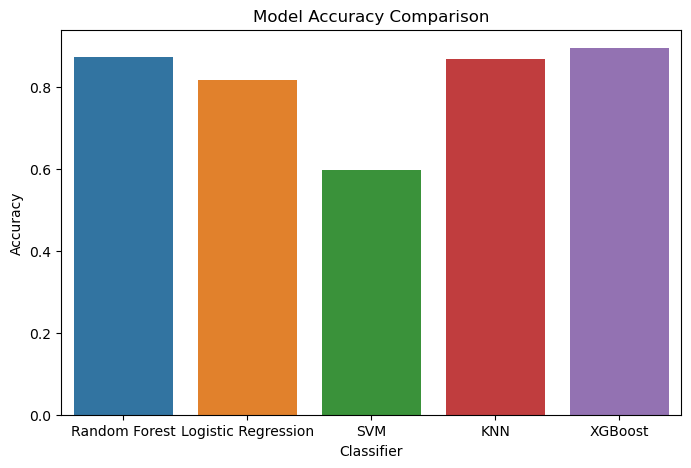

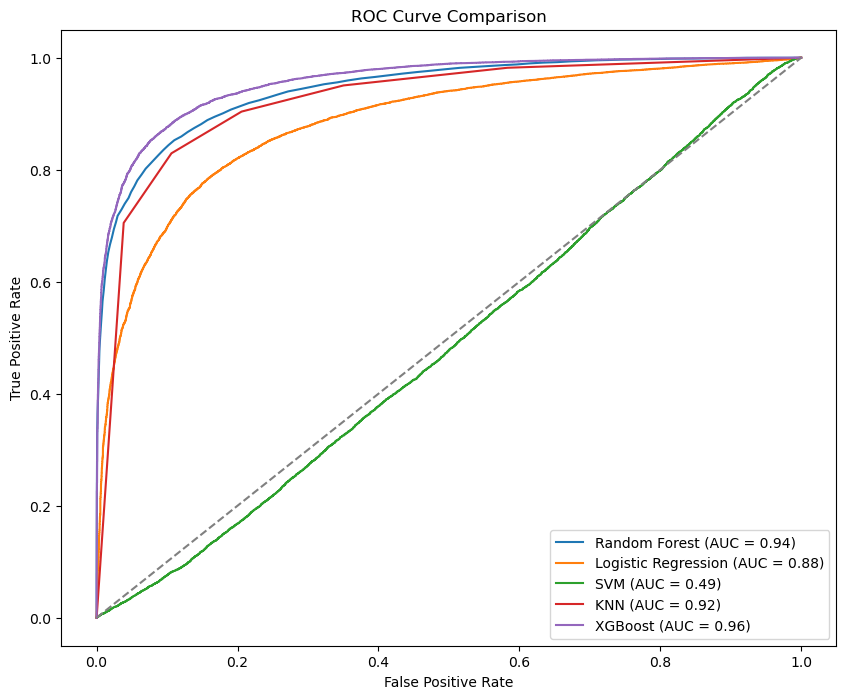

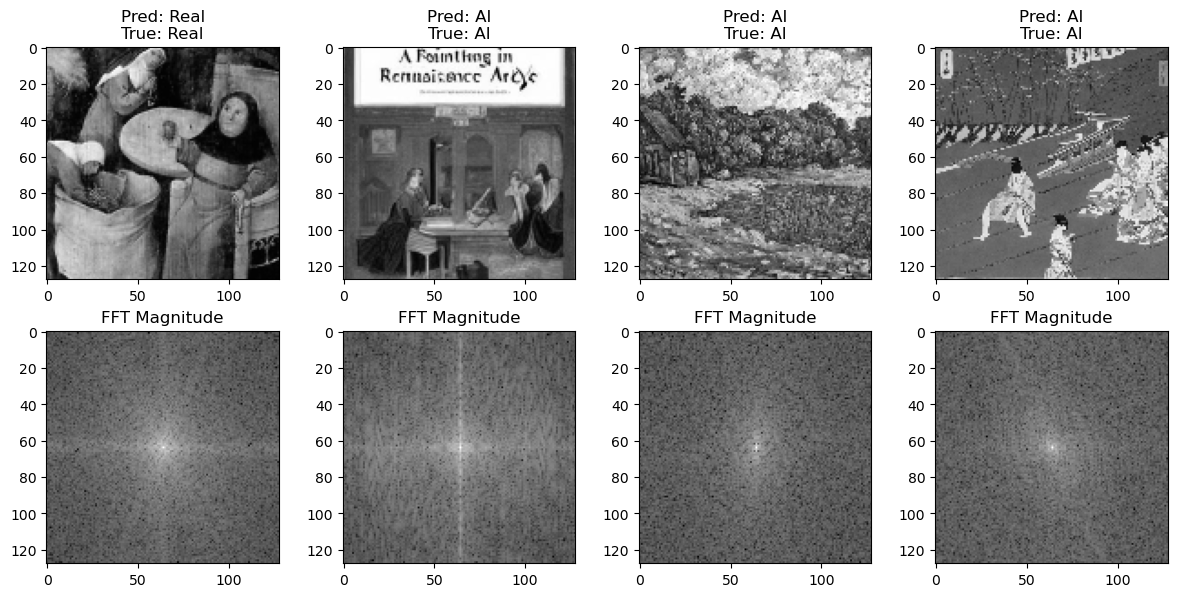

In [4]:
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
import kagglehub

# Download dataset
path = kagglehub.dataset_download("ravidussilva/real-ai-art")
print("Path to dataset files:", path)


# Helper function to load images
def load_images_from_folder(folder_path, label, max_samples=None):
    images, labels = [], []
    print(f"Loading images from: {folder_path}")
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        
        # Skip non-image files
        if not os.path.isfile(item_path):
            continue
        
        # Read and process the image
        img = cv2.imread(item_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        images.append(img)
        labels.append(label)
        
        if max_samples and len(images) >= max_samples:
            break

    print(f"Loaded {len(images)} images from {folder_path}")
    return np.array(images), np.array(labels)


# Function to plot ROC curves
def plot_roc_curves(results, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for name, metrics in results.items():
        y_score = metrics["model"].predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.title("ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()


# Load all train and test data
def load_datasets(base_path):
    styles = ['art_nouveau', 'baroque', 'expressionism', 'impressionism',
              'post_impressionism', 'realism', 'renaissance', 'romanticism',
              'surrealism', 'ukiyo-e']
    train_images, train_labels = [], []
    test_images, test_labels = [], []
    
    for style in styles:
        # Real images
        train_real, train_real_labels = load_images_from_folder(
            os.path.join(base_path, "Real_AI_SD_LD_Dataset/train", style), label=0)
        test_real, test_real_labels = load_images_from_folder(
            os.path.join(base_path, "Real_AI_SD_LD_Dataset/test", style), label=0)
        
        # AI-generated images
        for ai_type in ["AI_SD_", "AI_LD_"]:
            train_ai, train_ai_labels = load_images_from_folder(
                os.path.join(base_path, f"Real_AI_SD_LD_Dataset/train/{ai_type}{style}"), label=1)
            test_ai, test_ai_labels = load_images_from_folder(
                os.path.join(base_path, f"Real_AI_SD_LD_Dataset/test/{ai_type}{style}"), label=1)
            
            # Append AI data
            train_images.extend(train_ai)
            train_labels.extend(train_ai_labels)
            test_images.extend(test_ai)
            test_labels.extend(test_ai_labels)
        
        # Append real data
        train_images.extend(train_real)
        train_labels.extend(train_real_labels)
        test_images.extend(test_real)
        test_labels.extend(test_real_labels)
    
    return np.array(train_images), np.array(train_labels), np.array(test_images), np.array(test_labels)


# Apply FFT and preprocess dataset
def preprocess_fft(images):
    fft_images = [np.fft.fftshift(np.fft.fft2(img)) for img in images]
    fft_images_magnitude = [20 * np.log(np.abs(f) + 1) for f in fft_images]
    return np.array(fft_images_magnitude)


# Function to train and evaluate models with ROC curve calculation
def train_and_evaluate_with_proba(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {acc:.4f} (Training time: {train_time:.2f}s)")
        results[name] = {
            "accuracy": acc,
            "train_time": train_time,
            "y_pred": y_pred,
            "model": model
        }
    return results


# Choose between PCA and SVD
def dimensionality_reduction(method, train_data, test_data, n_components=50):
    if method == "PCA":
        reducer = PCA(n_components=n_components)
    elif method == "SVD":
        reducer = TruncatedSVD(n_components=n_components, random_state=42)
    else:
        raise ValueError("Unsupported dimensionality reduction method. Use 'PCA' or 'SVD'.")
    
    X_train = reducer.fit_transform(train_data)
    X_test = reducer.transform(test_data)
    return X_train, X_test, reducer


# Visualization helpers
def plot_accuracy(results):
    accuracies = [v["accuracy"] for v in results.values()]
    classifiers = list(results.keys())
    plt.figure(figsize=(8, 5))
    sns.barplot(x=classifiers, y=accuracies)
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.xlabel("Classifier")
    plt.show()


def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "AI"], yticklabels=["Real", "AI"])
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def plot_results(X_test, y_test, y_pred, images, test_indices):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, idx in enumerate(test_indices):
        original_img = images[idx]
        predicted_label = "Real" if y_pred[idx] == 0 else "AI"
        true_label = "Real" if y_test[idx] == 0 else "AI"
        axes[0, i].imshow(original_img, cmap="gray")
        axes[0, i].set_title(f"Pred: {predicted_label}\nTrue: {true_label}")
        fft_img = preprocess_fft([original_img])[0]
        axes[1, i].imshow(fft_img, cmap="gray")
        axes[1, i].set_title("FFT Magnitude")
    plt.tight_layout()
    plt.show()


# Main workflow
train_images, train_labels, test_images, test_labels = load_datasets(path)
train_fft = preprocess_fft(train_images)
test_fft = preprocess_fft(test_images)

# Flatten FFT data
train_fft_flat = train_fft.reshape(train_fft.shape[0], -1)
test_fft_flat = test_fft.reshape(test_fft.shape[0], -1)

# Dimensionality reduction
method = "PCA"  # Change to "SVD" to use SVD
X_train, X_test, reducer = dimensionality_reduction(method, train_fft_flat, test_fft_flat)

# Classifiers to compare
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="lbfgs"),
    "SVM": SVC(kernel="linear", probability=True, max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Train and evaluate models
results = train_and_evaluate_with_proba(models, X_train, train_labels, X_test, test_labels)

# Plot accuracy
plot_accuracy(results)

# Plot ROC curves
plot_roc_curves(results, X_test, test_labels)

# Plot sample predictions
test_indices = np.random.choice(len(test_labels), 4, replace=False)
plot_results(test_images, test_labels, results["Random Forest"]["y_pred"], test_images, test_indices)


C:\Users\zakeri\AppData\Local\anaconda3\envs\mostafa\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


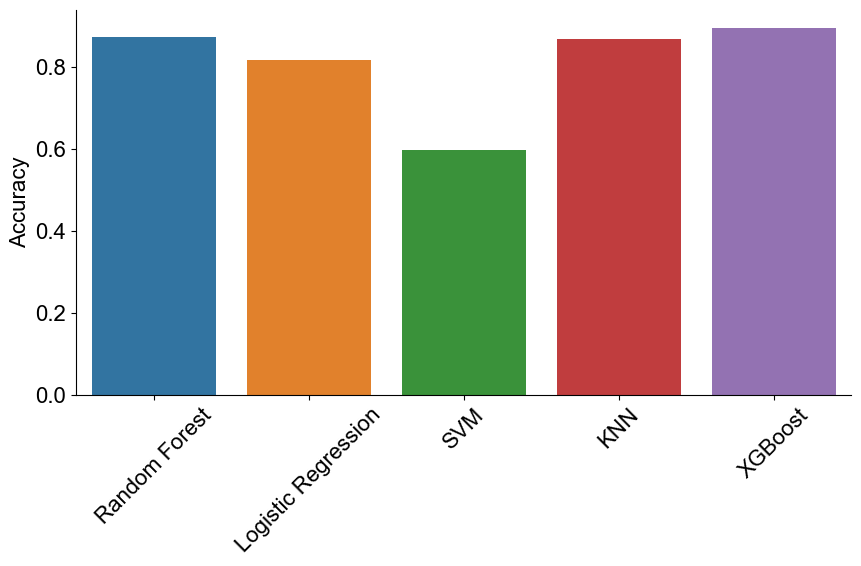

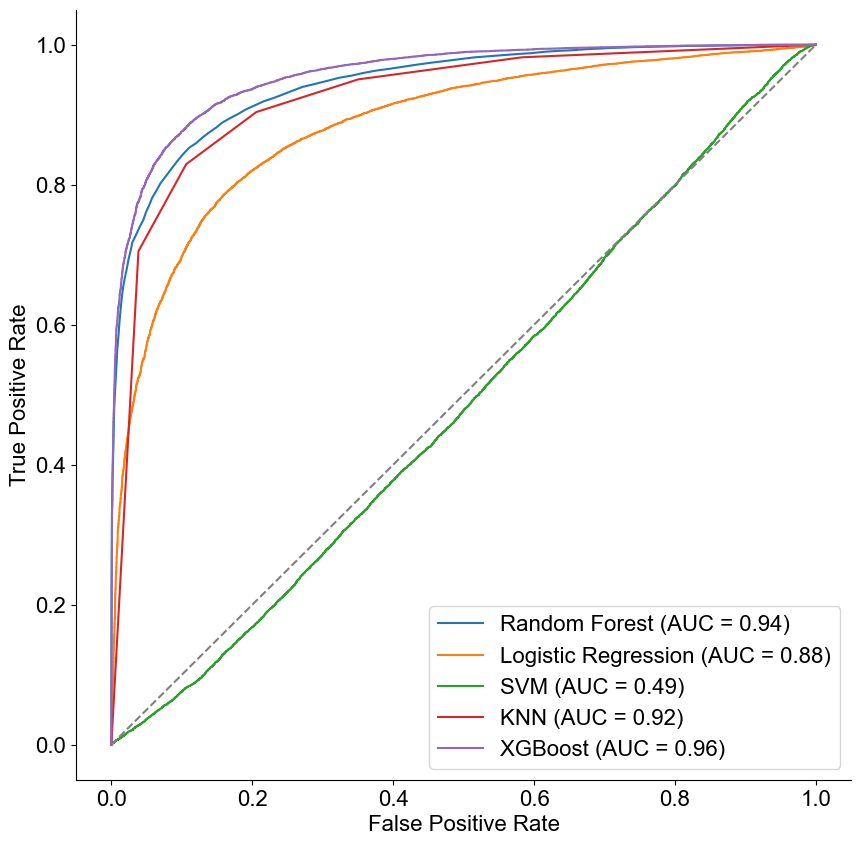

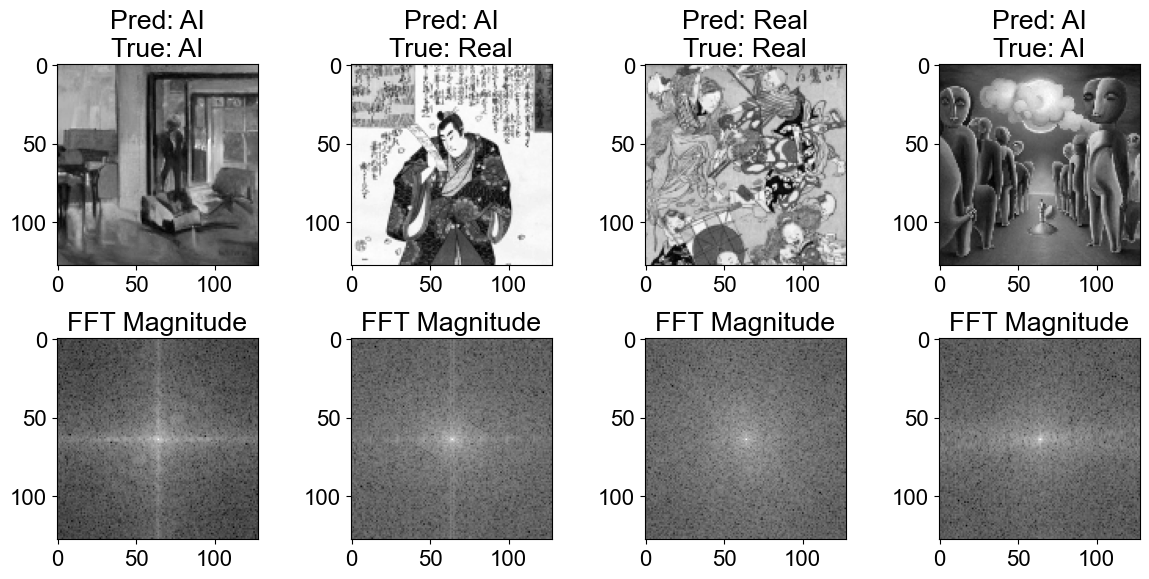

In [12]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 16

def plot_accuracy(results):
    accuracies = [v["accuracy"] for v in results.values()]
    classifiers = list(results.keys())
    plt.figure(figsize=(10, 5))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    sns.barplot(x=classifiers, y=accuracies)
    plt.xticks(rotation=45) 
    plt.ylabel("Accuracy")
    plt.show()

def plot_roc_curves(results, X_test, y_test):
    plt.figure(figsize=(10, 10))
    for name, metrics in results.items():
        y_score = metrics["model"].predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    # plt.title("ROC Curve Comparison")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

# Plot accuracy
plot_accuracy(results)

# Plot ROC curves
plot_roc_curves(results, X_test, test_labels)

# Plot sample predictions
test_indices = np.random.choice(len(test_labels), 4, replace=False)
plot_results(test_images, test_labels, results["Random Forest"]["y_pred"], test_images, test_indices)

Running with PCA...


C:\Users\zakeri\AppData\Local\anaconda3\envs\mostafa\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Training Random Forest...
Random Forest Accuracy: 0.8734 (Training time: 457.95s)
Training Logistic Regression...
Logistic Regression Accuracy: 0.8170 (Training time: 1.63s)
Training SVM...


C:\Users\zakeri\AppData\Local\anaconda3\envs\mostafa\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM Accuracy: 0.4391 (Training time: 104.82s)
Training KNN...
KNN Accuracy: 0.8688 (Training time: 0.06s)
Training XGBoost...
XGBoost Accuracy: 0.8916 (Training time: 11.20s)
Running with SVD...


C:\Users\zakeri\AppData\Local\anaconda3\envs\mostafa\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Training Random Forest...
Random Forest Accuracy: 0.8776 (Training time: 465.31s)
Training Logistic Regression...
Logistic Regression Accuracy: 0.8143 (Training time: 3.13s)
Training SVM...


C:\Users\zakeri\AppData\Local\anaconda3\envs\mostafa\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM Accuracy: 0.5864 (Training time: 99.77s)
Training KNN...
KNN Accuracy: 0.8668 (Training time: 0.03s)
Training XGBoost...
XGBoost Accuracy: 0.8925 (Training time: 11.20s)

Comparison of PCA vs. SVD:
Random Forest: PCA = 0.8734, SVD = 0.8776
Logistic Regression: PCA = 0.8170, SVD = 0.8143
SVM: PCA = 0.4391, SVD = 0.5864
KNN: PCA = 0.8688, SVD = 0.8668
XGBoost: PCA = 0.8916, SVD = 0.8925


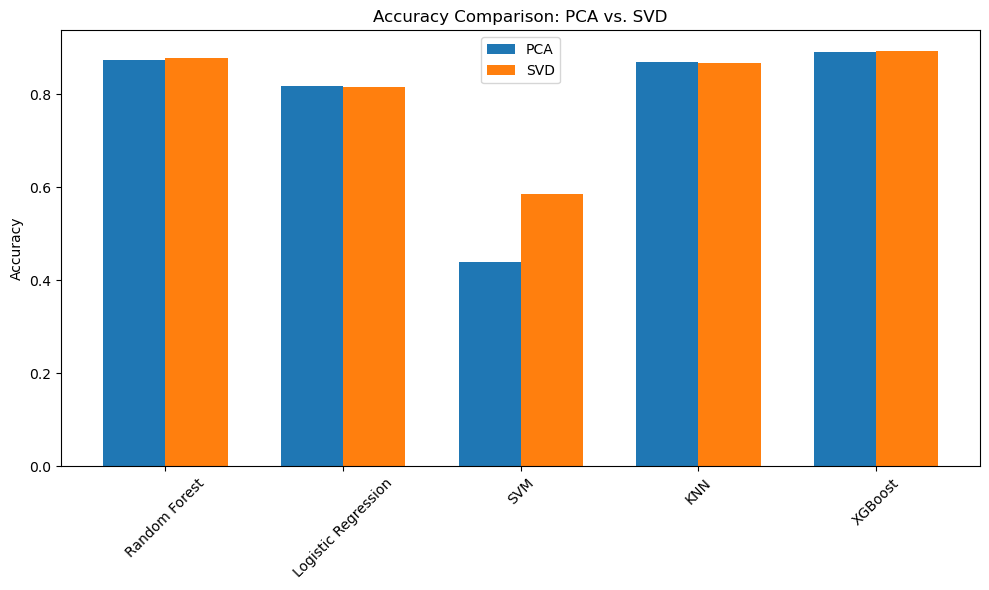

In [5]:
# Function to train and evaluate with a specified dimensionality reduction method
def train_with_dimensionality_reduction(method, train_fft_flat, test_fft_flat, train_labels, test_labels):
    print(f"Running with {method}...")
    # Apply dimensionality reduction
    X_train, X_test, reducer = dimensionality_reduction(method, train_fft_flat, test_fft_flat)
    
    # Train and evaluate models
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, solver="lbfgs"),
        "SVM": SVC(kernel="linear", probability=True, max_iter=1000),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    }
    results = train_and_evaluate_with_proba(models, X_train, train_labels, X_test, test_labels)
    return results

# Run for PCA
results_pca = train_with_dimensionality_reduction("PCA", train_fft_flat, test_fft_flat, train_labels, test_labels)

# Run for SVD
results_svd = train_with_dimensionality_reduction("SVD", train_fft_flat, test_fft_flat, train_labels, test_labels)

# Compare accuracies for PCA and SVD
def compare_results(results_pca, results_svd):
    comparison = {}
    for model in results_pca.keys():
        pca_acc = results_pca[model]["accuracy"]
        svd_acc = results_svd[model]["accuracy"]
        comparison[model] = {"PCA Accuracy": pca_acc, "SVD Accuracy": svd_acc}
    return comparison

comparison = compare_results(results_pca, results_svd)

# Print comparison
print("\nComparison of PCA vs. SVD:")
for model, metrics in comparison.items():
    print(f"{model}: PCA = {metrics['PCA Accuracy']:.4f}, SVD = {metrics['SVD Accuracy']:.4f}")

# Visualize comparison
def plot_comparison(comparison):
    models = comparison.keys()
    pca_acc = [metrics["PCA Accuracy"] for metrics in comparison.values()]
    svd_acc = [metrics["SVD Accuracy"] for metrics in comparison.values()]

    x = np.arange(len(models))  # Label locations
    width = 0.35  # Bar width

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, pca_acc, width, label="PCA")
    plt.bar(x + width/2, svd_acc, width, label="SVD")
    
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison: PCA vs. SVD")
    plt.xticks(x, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot comparison
plot_comparison(comparison)


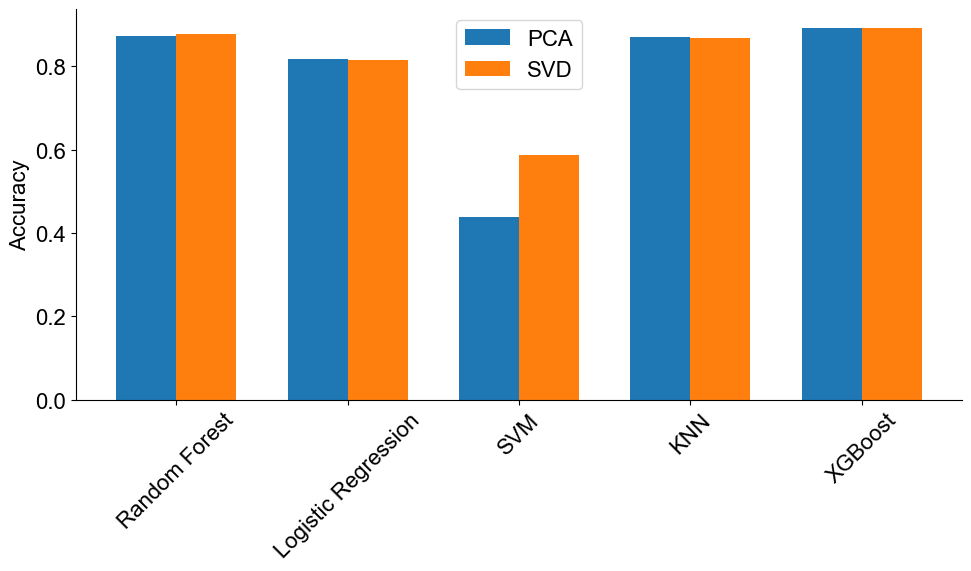

In [13]:
def plot_comparison(comparison):
    models = comparison.keys()
    pca_acc = [metrics["PCA Accuracy"] for metrics in comparison.values()]
    svd_acc = [metrics["SVD Accuracy"] for metrics in comparison.values()]

    x = np.arange(len(models))  # Label locations
    width = 0.35  # Bar width

    plt.figure(figsize=(10, 6))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.bar(x - width/2, pca_acc, width, label="PCA")
    plt.bar(x + width/2, svd_acc, width, label="SVD")
    
    plt.ylabel("Accuracy")
    # plt.title("Accuracy Comparison: PCA vs. SVD")
    plt.xticks(x, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot comparison
plot_comparison(comparison)